# Examining Brooklyn Data

First, it is necessary to import the packages needed for the analysis and visualizations.

In [1]:
import pandas as pd
import numpy as np
# Visualization packages
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import graphviz
import datetime as dt
import random
# Data preparation and analysis packages
from sklearn import datasets, linear_model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
# useful function for dividing dataset into training and test set
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
# Error/Score measurements
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance

%matplotlib inline

These are the functions needed for preparing the data when reading the data frame from the csv file. Performing all these functions at the beginning makes the code cleaner and more clearly arranged.
- time_of_day(hour) is dividing the hours of the day in bigger categories that we considered to be interesting when talking about (taxi) traffic.
- checkWeekday(day) checks if a day is a weekday or a weekend day
- calcMinSinceMidnight(dt) calculates the minutes that have passed since midnight from the datetime object
- groupMinSinceMidnight(m) categorizes the minutes since midnight column into larger intervals

In [2]:
# functions needed for data prep

def time_of_day(hour):
    if hour<6:
        return "night"
    elif hour<10:
        return "morning rush"
    elif hour<16:
        return "daytime"
    elif hour<19:
        return "evening_rush"
    else:
        return "night"
    
def checkWeekday(day):
    n = day.isoweekday()
    if n<6:
        return 1
    else:
        return 0
    
def calcMinSinceMidnight(dt):
    min_since_midnight = (dt.hour*60 + dt.minute)
    return min_since_midnight
    
def groupMinSinceMidnight(m):
    for minInt in range(0, 1445, 30):
        if m < minInt:
            return minInt

The steps for importing and preparing the data are the following:
1. Read the csv-file
2.  - As the columns have different names in the pickups and dropoffs datasets, one needs to first find the columns holding the certain values, as it is for example done here finding the 'datetime' column, giving it a more general name such that more generic functions can be performed on it.
    - The values in this datetime columns are then cast to datetime objects (they are strings when they are imported).
    - To order the rows by the datetime, this column is then set as an index. Later, the index is reset in order to make it easier to access the column.
3. A column just containing the date is added.
4. More general latitude and longitude columns are added (see 2. for how to find these)
5. A weekday column is added stating if the day is a weekday or not.
6. A time of day is assigned to each row.
7. The minutes since midnight are calculated and grouped in 30 minutes intervals.
8. The coordinates are collected in one 'location'-column.
9. Unused/ Useless columns are deleted.


In [3]:
def importAndPrepareData(filepath):
    # check if tsv or csv
    impdf = pd.read_csv(filepath, delimiter=',')
    
    datetimeCol = [col for col in impdf.columns if 'datetime' in col]
    impdf['datetime'] = impdf[datetimeCol[0]].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    impdf = impdf.set_index('datetime')
    impdf = impdf.reset_index()
    
    # add a column just containing the date
    impdf['date'] = impdf['datetime'].apply(lambda x: x.date())
    
    # more general lat and lon column names
    lonCol = [col for col in impdf.columns if 'longitude' in col]
    impdf['lon'] = impdf[lonCol[0]]
    latCol = [col for col in impdf.columns if 'latitude' in col]
    impdf['lat'] = impdf[latCol]
    
    # weekday or weekend-day?
    impdf['weekday'] = [checkWeekday(x) for x in impdf['datetime']]
    #TODO: add column saying if this day is an event day or not
    
    # assign time of day to each row
    impdf['time_of_day'] = [time_of_day(x) for x in impdf['datetime'].dt.hour]
    
    # calculate minutes since midnight for each row and group them
    impdf['min_since_midnight'] = [calcMinSinceMidnight(line) for line in impdf['datetime']]
    impdf['min_since_midnight_group'] = [groupMinSinceMidnight(m) for m in impdf['min_since_midnight']]
    
    # collect coordinates in one column
    impdf['location'] = np.nan
    loc = []
    for i in range(len(impdf['lat'].values)):
        loc.append((impdf['lon'].values[i], impdf['lat'].values[i]))
    impdf['location'] = loc
    
    randomCol = [col for col in impdf.columns if 'Unnamed' in col]
    for rc in randomCol: del impdf[rc]
    del impdf['min_since_midnight']

    return impdf

These steps are performed both on the Pickups_Brooklyn_June and the Dropoffs_Brooklyn_June dataset:

In [4]:
pickupDF = importAndPrepareData('Pickups_Brooklyn_June.csv')
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,trip_distance,date,lon,lat,weekday,time_of_day,min_since_midnight_group,location
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,0.70,2016-06-09,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)"
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,2.02,2016-06-09,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)"
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,5.56,2016-06-09,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)"
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,4.20,2016-06-09,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)"
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,2.30,2016-06-09,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)"


After importing the data, we decided it would make sense to divide the places into areas. For this purpose, we use the KMeans algorithm to divide the area into evenly distributed clusters. We decided to divide the area into 10 clusters.
The function kmeansOnLocation(df, k=10) takes in a data frame and performs clustering by longitude and latitude. It then adds an extra column of the kmeans_cluster to the dataframe and returns both the modified dataframe and the kmeans object.

To examine how well the clustering is performed, we calculate the silhouette and distortion of the clustering:
The silhouette measures the between-cluster variability, that means, the distance in between the clusters. This should be maximized.
Distortion is a measure for the inter-cluster variability; how far the points in the cluster are away from each other. This should be minimized.

kmeansSilhouette(df) is used to calculate the silhouette. It takes in the data frame and first calculates the pairwise distances between each of the points, then, the silhouette_score function is used to calculate the silhouette. We use the 'manhattan' distance as metric for calculating the silhouette, as Brooklyn, like Manhattan, consists of blocks, so measuring the distance by blocks seems to make sense here.
The distortion can easily be retrieved by the .inertia property of the kmeans object.

In [5]:
def kmeansOnLocation(df, k=10):
    #perform kmeans
    K_allData = k
    k_allData = KMeans(K_allData, random_state=3)
    k_allData.fit(df[['lat', 'lon']])
    
    # new column in dataframe for location cluster
    df['kmeans_cluster'] = k_allData.labels_
    
    # computing and printing the score of the clustering
    print('------Scores of K-Mean Clustering on dataframe ----------\n'+'silhouette:'+str(kmeansSilhouette(df))+
    '\n'+'distortion: '+str(k_allData.inertia_))
    
    return df, k_allData # returns df with added column from clustering

def kmeansSilhouette(df):
    sampledf = df.sample(n=1000)
    coords = []
    for i in range(len(sampledf['lon'].values)):
        coords.append([sampledf['lon'].values[i], sampledf['lat'].values[i]])
    pwdist = pairwise_distances(coords, metric='manhattan')
    silhouette_avg = silhouette_score(pwdist, sampledf['kmeans_cluster'], metric="precomputed")
    return silhouette_avg

def plotClusters(df, clusterCol='kmeans_cluster'):
    num_colors=len(set(df[clusterCol].values))
    colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
    cluster_colors=random.choices(colors, k=num_colors)
    for i in range(0, num_colors):
        print('Color for cluster '+str(i)+': '+ cluster_colors[i])
    print('Barclays Center: black')
    x_=[]
    y_=[]
    c_=[]
    for label, x, y in zip(df[clusterCol].values, df['lon'].values, df['lat'].values):
        if label==-1:
            continue
        x_.append(x)
        y_.append(y)
        c_.append(cluster_colors[label])
    plt.scatter(x_,y_,s=0.3,c=c_)
    plt.scatter(-73.974689,40.68265, c='black')

In [6]:
pickupDF, kPickup = kmeansOnLocation(pickupDF)

------Scores of K-Mean Clustering on dataframe ----------
silhouette:0.43815465086
distortion: 12.1385084167


Color for cluster 0: goldenrod
Color for cluster 1: seagreen
Color for cluster 2: darkgoldenrod
Color for cluster 3: cornsilk
Color for cluster 4: rosybrown
Color for cluster 5: forestgreen
Color for cluster 6: gold
Color for cluster 7: powderblue
Color for cluster 8: lightslategrey
Color for cluster 9: darkorchid
Barclays Center: black


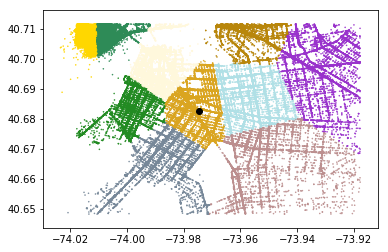

In [7]:
plotClusters(pickupDF)

As we now have divided the area into smaller clusters, we can start to examine the data according to their location, the cluster their location belongs to.
Note that Barclays Center is located in cluster 6.

# Identification of popular pickup areas and prediction for pickups

We would like to make predictions for the areas defined by the clusters above, that is the reason why we first group the data by date, minute since midnight and cluster and sum up the number of pickups.
Then, we create a dataframe for each cluster, applying the function buildDataFramesForClusterDF(df) to the dataframe containing the counts. These dataframes are then merged again, such that we end up with a dataframe containing the date and the minutes since midnight and the counts for the pickups at that time for each of the clusters.

In [8]:
def getCountsFromDF(df):
    df['count'] = 1
    countDF = pd.DataFrame.groupby(df,by=['date', 'min_since_midnight_group', 'kmeans_cluster']).sum()
    countDF = countDF.reset_index()
    columns = ['date', 'min_since_midnight_group', 'kmeans_cluster', 'count']
    countDF = countDF[columns]
    return countDF

In [9]:
countPickupDF = getCountsFromDF(pickupDF)

In [11]:
def buildDataFramesForClusterDF(df):
    # dictionary for clusters
    pickups_brooklyn_clusters = {}
    date = {}
    min_since_midnight = {}
    count = {}
    d = {}
    dft = {}
    for c in range(0, 10):
        pickups_brooklyn_clusters[c] = df[df['kmeans_cluster'] == c]
        date[c] = pickups_brooklyn_clusters[c]['date'].values
        min_since_midnight[c] = pickups_brooklyn_clusters[c]['min_since_midnight_group'].values
        count[c] = pickups_brooklyn_clusters[c]['count'].values
        d = {'date': date[c], 'min_since_midnight': min_since_midnight[c], 'count': count[c]}
        dft[c] = pd.DataFrame(d)
    
    mergedft = pd.merge(dft[0], dft[1], on=['date', 'min_since_midnight'], how='inner', suffixes=('_0', '_1'))
    
    for c in range(2, 10):
        mergedft = pd.merge(mergedft, dft[c], on=['date', 'min_since_midnight'], how='inner', suffixes=('', '_'+str(c)))
    mergedft = mergedft.rename(columns={'count': 'count_2'})

    return dft, mergedft

In [12]:
pickupCountDict, mergedPickupCountClusters = buildDataFramesForClusterDF(countPickupDF)

In [13]:
mergedPickupCountClusters.head()

,count_0,date,min_since_midnight,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
0,21,2016-06-01,30,52,20,20,10,12,37,12,9,17
1,27,2016-06-01,60,34,12,21,9,4,22,15,11,21
2,16,2016-06-01,90,28,18,17,10,5,19,10,6,19
3,13,2016-06-01,120,27,6,6,6,5,17,9,5,12
4,10,2016-06-01,150,16,12,11,5,5,14,5,3,7


Now, we would like to take a closer look at the pickups in the different areas in the course of a day and get a general impression of the number of pickups in the specific area. That is why we produce three plots for each cluster:
1. The histogram of pickup counts
2. The pickup counts according to the time of the day
3. The mean, 5% quantile and 95% quantile of the number of pickups, the quantiles defining an upper and lower bound of the usual number of pickups in this area and giving an impression about the variance

In [14]:
def plots(input_df, k):
    
    fig = plt.figure(figsize=(10, 10))
    
    # histogram
    ax1 = fig.add_subplot(221)
    input_df['count'].hist(bins=25)
    plt.ylabel('frequency')
    plt.xlabel('#pickups')
    plt.title('Histogram of pickup counts in area '+str(k))

    # scatterplot with colours

    ax3 = fig.add_subplot(222)
    ax3.scatter(range(len(input_df['count'])), input_df['count'], c=input_df['min_since_midnight'], s=10)
    plt.title('Pickup counts coloured according to minutes passed in area '+str(k))

    # plot with mean and quantiles 
    df_grouped = input_df.groupby('min_since_midnight').sum()
    df_grouped['means'] = input_df.groupby('min_since_midnight').mean()
    df_grouped['quantile_5'] = input_df.groupby('min_since_midnight').quantile(0.05)
    df_grouped['quantile_95'] = input_df.groupby('min_since_midnight').quantile(0.95)

    x = df_grouped.index
    
    ax4 = fig.add_subplot(223)
    ax4.plot(x, df_grouped.means, c='pink')
    ax4.plot(x, df_grouped.quantile_5, c='green')
    ax4.plot(x, df_grouped.quantile_95, c='orange')
    plt.xlabel('minutes since midnight')
    plt.ylabel('# pickups')
    plt.title('Average, percentile 5 and percentile 95 pickups on a day in area '+str(k))
    plt.legend()

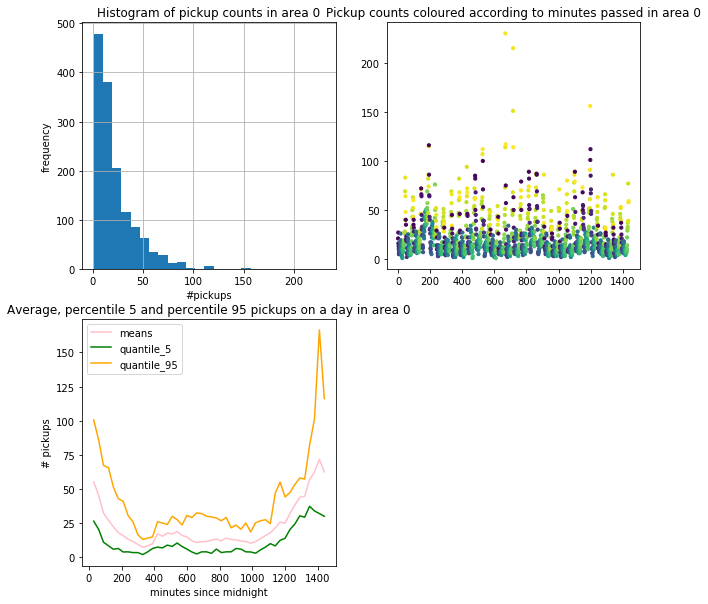

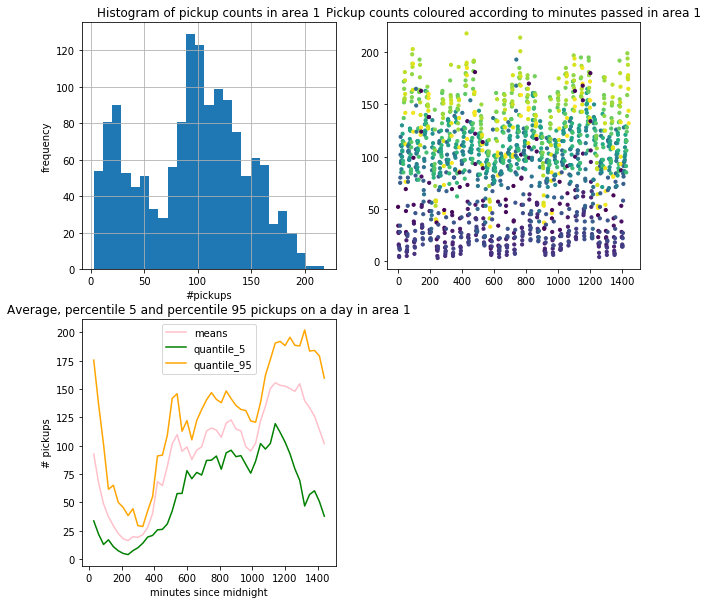

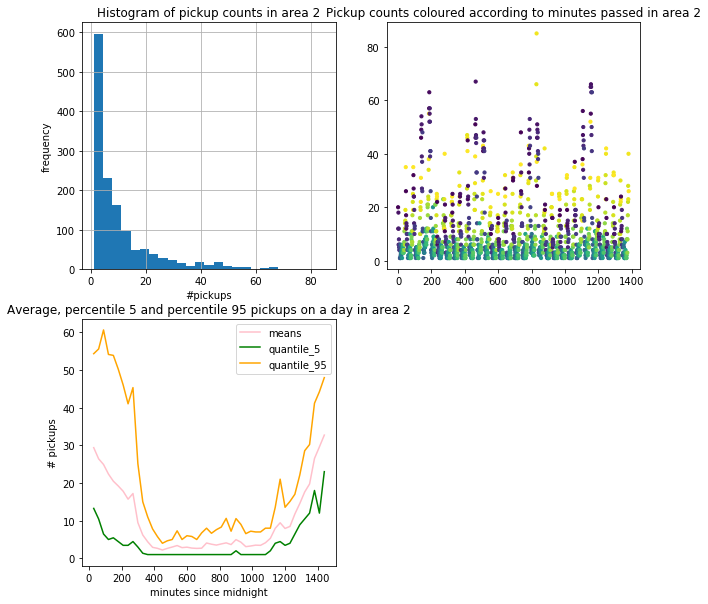

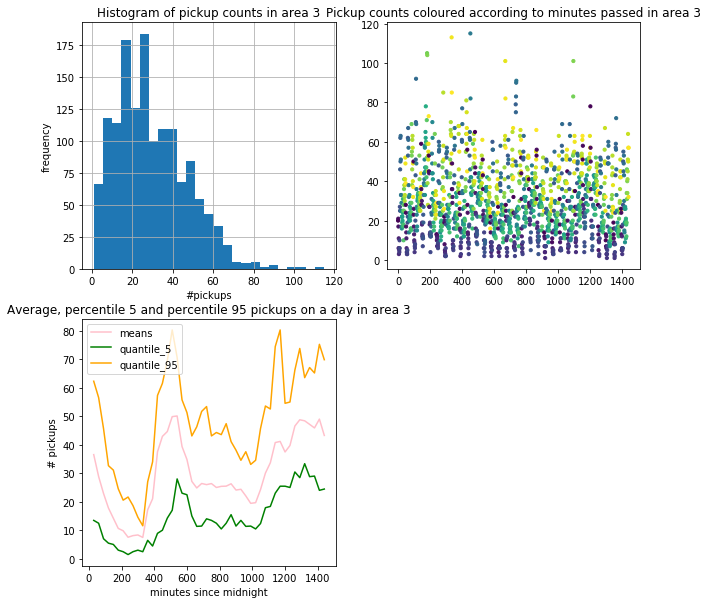

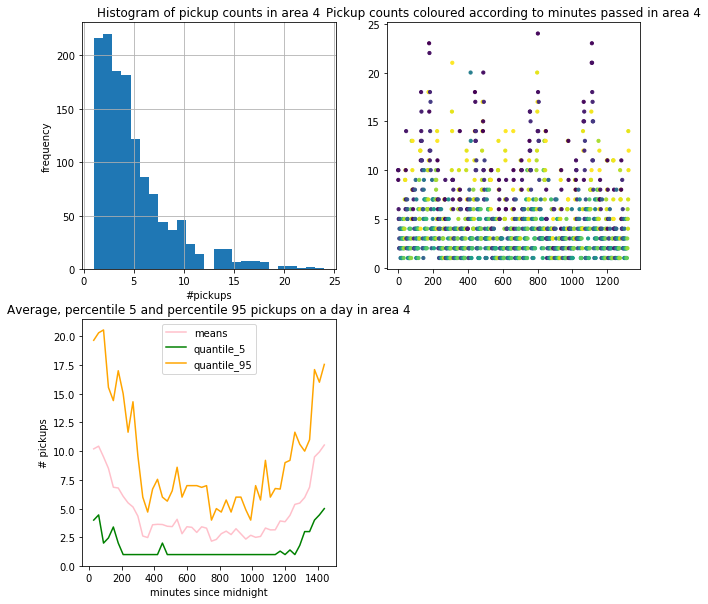

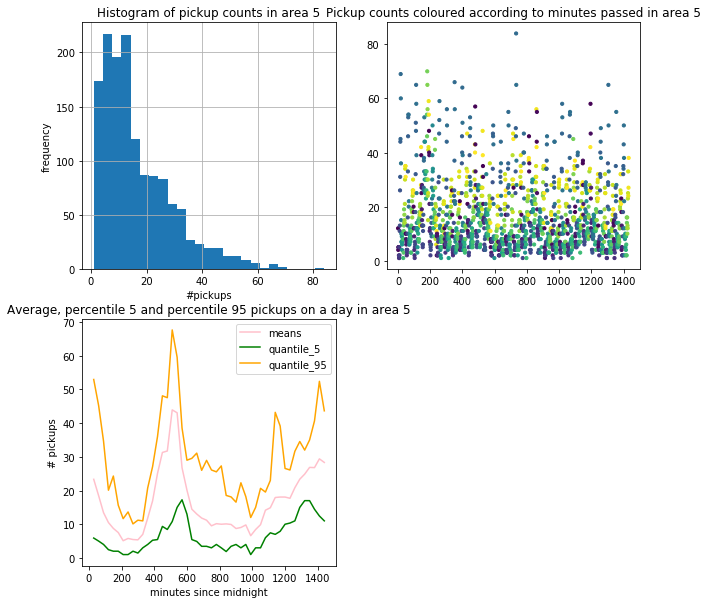

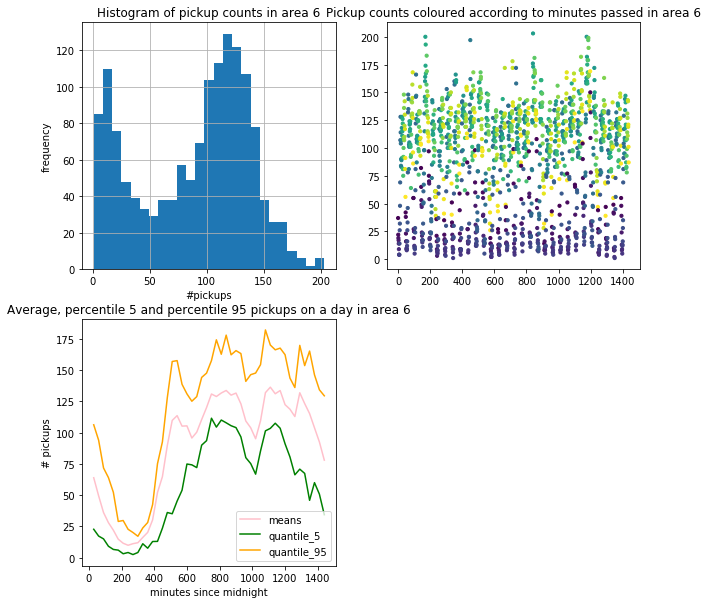

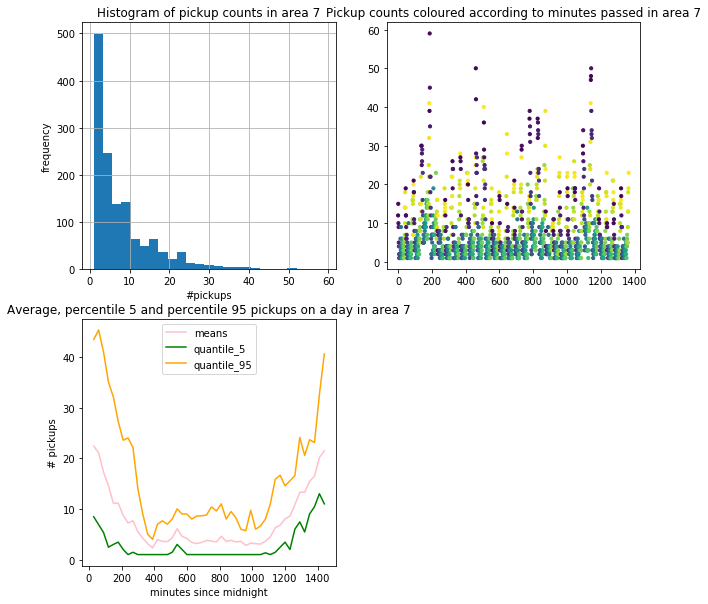

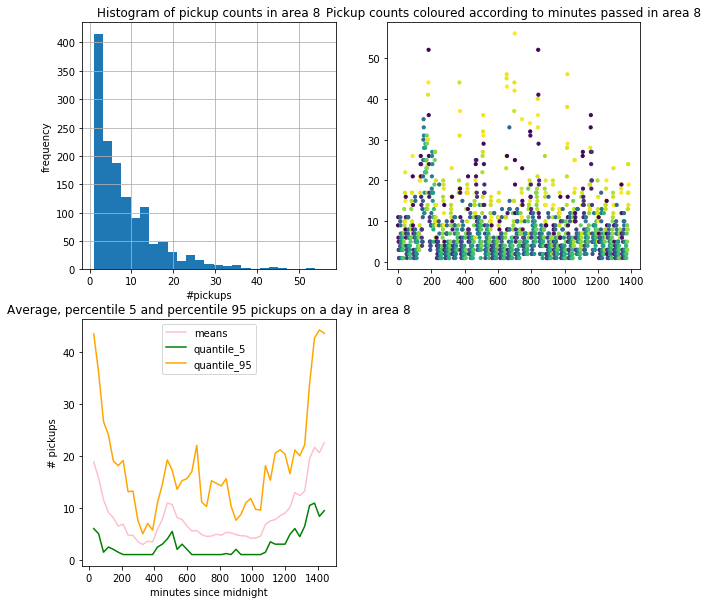

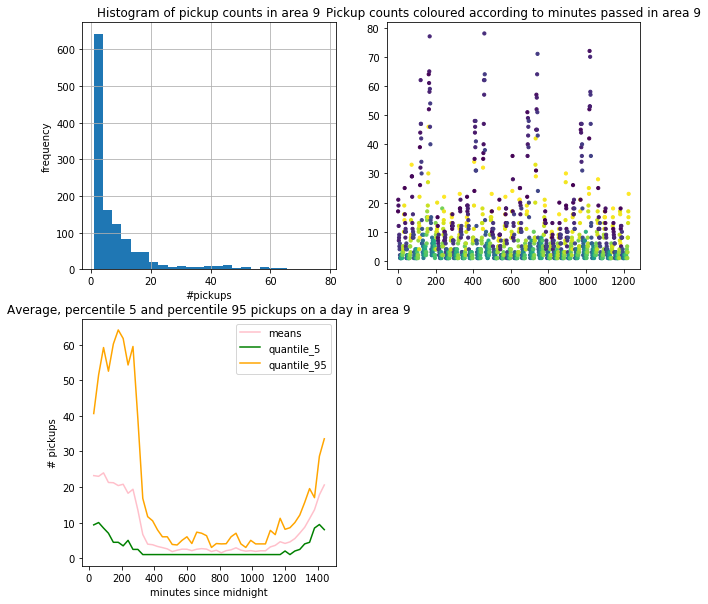

In [15]:
for k in list(pickupCountDict.keys()):
    plots(pickupCountDict[k], k)

Apparently, Area 1 and area 6 are quite popular areas, reading from the histogram counting the occurrence of a certain number of pickups. While the other areas seem to have a maxiumum number of pickup counts of 80 or less, these areas have a big amount of pickup counts above 100.
Looking closer at these areas, one can see that area 1 has a high demand ( >100 pickups) from around 11 AM and from then until midnight, the pickup counts are nearly all the time over 100. However, from 6 PM, the variance gets quite high, but still, from 10 AM to 6 PM, this seems to be a good spot for a taxi driver to be.
Area 6 has two high-demand time zones, one ranging from 1130 AM to 2 PM and the other one between 6 and 9 PM. This area seems to be quite a steady area compared to area 1, as the variance is quite constant during this high-demand period, judging from the average and percentiles plot.

These observations are also visible looking at the statistical measures of the dataframe:

In [16]:
def convertMinToTime(minutesDelta):
    if minutesDelta == 1440:
        return dt.time(0, 0)
    else:
        hours = minutesDelta //60
        minutes = minutesDelta % 60
        return dt.time(hours, minutes)

def recombinedDatetimeCol(df):
    df['timetime'] = df['min_since_midnight'].apply(lambda x: convertMinToTime(x))
    df['datetime'] = [dt.datetime.combine(d, t) for d, t in zip(df['date'], df['timetime'])]
    del df['min_since_midnight']
    del df['date']
    df = df.set_index('datetime')
    return df

In [17]:
mergedPickupCountClustersRecombinedDT = recombinedDatetimeCol(mergedPickupCountClusters.copy())

In [18]:
mergedPickupCountClustersRecombinedDT.describe()

,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,27.660936,94.231137,12.659981,31.961796,5.383954,18.298949,85.381089,9.420248,9.861509,9.868195
std,22.997519,53.281335,13.135816,18.699354,4.041568,13.112815,51.639293,8.496602,8.440259,12.744879
min,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,44.000000,4.000000,17.000000,2.000000,8.500000,31.500000,3.000000,4.000000,2.000000
50%,21.000000,101.000000,8.000000,30.000000,4.000000,15.000000,98.000000,6.000000,7.000000,5.000000
75%,36.500000,135.000000,17.000000,44.000000,7.000000,26.000000,127.000000,13.000000,13.000000,12.000000
max,230.000000,218.000000,85.000000,115.000000,24.000000,84.000000,203.000000,59.000000,56.000000,78.000000


Area 1 and 6 have by far the highest means, but unfortunately also the highest standard deviations.
As mentioned above, judging from the figures, the standard deviation during the high-demand times in area 5 is not as bad, but this situation is a bit more serious for area 1.

Another part of our prediction model will examine if there is any correlation between the pickups in the different areas.

In [19]:
def draw_correlation_matrix(corrDf):
    print(corrDF)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 15)
    cax = ax1.imshow(corrDf, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation between pickup areas')
    labels=list(corrDf.columns)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.set_xticklabels(labels,fontsize=5)
    ax1.set_yticklabels(labels,fontsize=8)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-.3,-.2,-.1,.0,.1,.2,.3,.4,.5, .6,.7, .8,.90,1])
    plt.show()

          count_0   count_1   count_2   count_3   count_4   count_5   count_6  \
count_0  1.000000  0.360561  0.662328  0.550945  0.595735  0.505599  0.241633   
count_1  0.360561  1.000000  0.000185  0.689367 -0.020266  0.453761  0.898781   
count_2  0.662328  0.000185  1.000000  0.161454  0.758304  0.199113 -0.136497   
count_3  0.550945  0.689367  0.161454  1.000000  0.205669  0.773692  0.644716   
count_4  0.595735 -0.020266  0.758304  0.205669  1.000000  0.271111 -0.121991   
count_5  0.505599  0.453761  0.199113  0.773692  0.271111  1.000000  0.445803   
count_6  0.241633  0.898781 -0.136497  0.644716 -0.121991  0.445803  1.000000   
count_7  0.752144  0.126390  0.826019  0.318352  0.747568  0.337847 -0.009371   
count_8  0.814179  0.301191  0.596007  0.525421  0.598684  0.560648  0.220732   
count_9  0.436375 -0.230477  0.842862 -0.049860  0.702392  0.037791 -0.328496   

          count_7   count_8   count_9  
count_0  0.752144  0.814179  0.436375  
count_1  0.126390  0.301191 

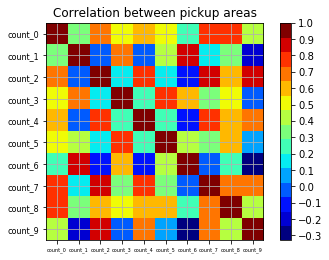

In [20]:
corrDF = mergedPickupCountClustersRecombinedDT.corr()
draw_correlation_matrix(corrDF)

As one can see in the legend, the more red-ish the fields are, the more are the pickups correlated. There seems to be very high correlations between the following areas:
- 1 and 6
- 2 and 7, 9

And quite high correlations between the areas:
- 0 and 7, 8
- 2 and 4
- 3 and 5
- 4 and 7

Now, the correlations between the lagged counts are to be examined:

In [21]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [22]:
countCols = [col for col in mergedPickupCountClustersRecombinedDT.columns if 'count_' in col]
mergedPickupCountsLagged = buildLaggedFeatures(mergedPickupCountClustersRecombinedDT, countCols)

In [23]:
def draw_correlation_matrix_for_lags(corrDf):
    print(corrDF)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(corrDf, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation between pickup areas and their lags')
    labels=list(corrDf.columns)
    ax1.set_xticks(list(range(0,len(corrDf))))
    ax1.set_yticks(list(range(0,len(corrDf))))
    ax1.set_xticklabels(labels,fontsize=5)
    ax1.set_yticklabels(labels,fontsize=8)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-.3,-.2,-.1,.0,.1,.2,.3,.4,.5, .6,.7, .8,.90,1])
    plt.show()

          count_0   count_1   count_2   count_3   count_4   count_5   count_6  \
count_0  1.000000  0.360561  0.662328  0.550945  0.595735  0.505599  0.241633   
count_1  0.360561  1.000000  0.000185  0.689367 -0.020266  0.453761  0.898781   
count_2  0.662328  0.000185  1.000000  0.161454  0.758304  0.199113 -0.136497   
count_3  0.550945  0.689367  0.161454  1.000000  0.205669  0.773692  0.644716   
count_4  0.595735 -0.020266  0.758304  0.205669  1.000000  0.271111 -0.121991   
count_5  0.505599  0.453761  0.199113  0.773692  0.271111  1.000000  0.445803   
count_6  0.241633  0.898781 -0.136497  0.644716 -0.121991  0.445803  1.000000   
count_7  0.752144  0.126390  0.826019  0.318352  0.747568  0.337847 -0.009371   
count_8  0.814179  0.301191  0.596007  0.525421  0.598684  0.560648  0.220732   
count_9  0.436375 -0.230477  0.842862 -0.049860  0.702392  0.037791 -0.328496   

          count_7   count_8   count_9  
count_0  0.752144  0.814179  0.436375  
count_1  0.126390  0.301191 

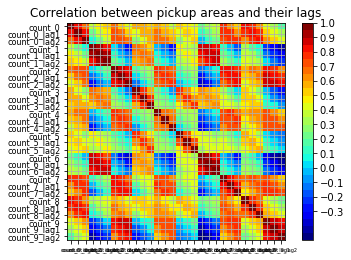

In [24]:
draw_correlation_matrix_for_lags(mergedPickupCountsLagged.corr())

As one can see, there is a very high correlation between
- lag 1 of area 6 and the count of area 1 and the count of area 6
- lag 1 of area 2 and the count of area 9
- lag 2 of area 2 and the count and lag 1 of area 9

We are especially interested in predicting the pickups for the popular area 6, that is why we try to find out if there really is a linear correlation between area 6 and area 1.

In [25]:
def calculateErrors(regr, x, y, y_pred):
    
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(y_pred - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
    % np.sqrt(np.mean((y_pred - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    print("R-squared: %.2f" %max(0, 1 - np.sum((y-y_pred)**2) / np.sum((y - np.mean(y))**2)))


def printScoresAndCoefficients(regr, x, y):
    y_pred = np.concatenate(regr.predict(x))
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    print('---Scores---')
    calculateErrors(regr, x, y, y_pred)
        
    m, b = np.polyfit(np.concatenate(y), y_pred, deg=1)
    plt.scatter(y, y_pred, s=2, color='black')
    #plt.plot(x[:,1], regr.predict(x), color='blue',linewidth=2)
    plt.plot(y, m*y+b, color='peru')
    plt.xlabel("predicted")
    plt.ylabel("observed")
    plt.show()

In [28]:
x=np.c_[np.ones(len(mergedPickupCountsLagged)),mergedPickupCountsLagged['count_1'], mergedPickupCountsLagged['count_6']]
y=np.array(mergedPickupCountsLagged['count_6_lag1'], ndmin=2).T

Coefficients: 
 [[ 3.2021276   0.25801691  0.67711443]]
---Scores---
Mean Absolute error (MAE): 56.78
Root Mean squared error: 70.28
Variance score: 0.85
R-squared: 0.00


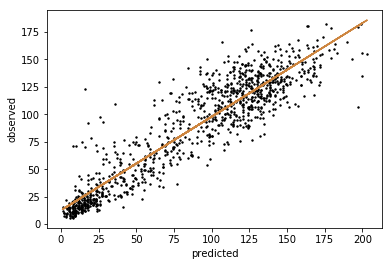

In [29]:
regr0=linear_model.LinearRegression(fit_intercept=False)
regr0.fit(x, y)
printScoresAndCoefficients(regr0, x, y)

Although the errors seem to be quite high, the prediction seems to be quite fitting for all pickup counts between 0 and 25 (low pickup count times) and not as good, but "okay-fitting" for the counts between 100 and 150 (high pickup count times).

# Prediction including event days

As we saw earlier, the variance of the number of pickups in area 6 was especially high in the evening time; the time events take place at Barclays Center. That is why we decided to include this in our analysis as well.

In [30]:
events = pd.read_csv('barclays_events.tsv', delimiter='\t')
events['start_time'] = events['start_time'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M"))
events = events.set_index('start_time')
del events['url']
events = events.fillna('')

In [31]:
event_days = events.index.date

In [32]:
def is_event_day(day):
    if day in event_days:
        return 1
    else:
        return 0

In [36]:
pickupsArea6 = pickupCountDict[6]

In [37]:
pickupsArea6['event_day'] = [is_event_day(d) for d in pickupsArea6.date]

In [38]:
pickupsArea6 = pickupsArea6.set_index('date')

In [39]:
pickupsArea6.head()

,count,min_since_midnight,event_day
date,,,
2016-06-01,37,30,1
2016-06-01,22,60,1
2016-06-01,19,90,1
2016-06-01,17,120,1
2016-06-01,14,150,1


In [40]:
def createTrainAndTestSets(df):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    split=int(len(df_shuffled)*2/3)
    trainset=df_shuffled[:split]
    testset=df_shuffled[split:]
    return trainset, testset

In [73]:
def predictPickupsInArea(df, alg='gaussian'):
    
    dftrain, dftest = createTrainAndTestSets(df)
    
    X = df[['min_since_midnight', 'event_day']]
    y = df['count']
    
    df_event_day = df[df['event_day']==1]
    X_event_day = df_event_day[['min_since_midnight', 'event_day']]
    y_event_day = df_event_day['count']
    df_non_event_day = df[df['event_day']==0]
    X_nonevent_day = df_non_event_day[['min_since_midnight', 'event_day']]
    y_nonevent_day = df_non_event_day['count']
    
    X_train = dftrain[['min_since_midnight', 'event_day']]
    y_train = dftrain['count']
    X_test = dftest[['min_since_midnight', 'event_day']]
    y_test = dftest['count']                  
    
    if alg=='gaussian':
        gp = GaussianProcessRegressor()
        gp.fit(X_train, y_train)
        print("Gaussian score on training set: "+str(gp.score(X_train, y_train)))
        print("Gaussian score on test set: "+str(gp.score(X_test, y_test)))
        print('\n\n')
        y_predNE = gp.predict(X_nonevent_day)
        print('Errors for nonevent day prediction:')
        calculateErrors(gp, X_nonevent_day, y_nonevent_day, y_predNE)
        
        fig = plt.figure()
        plt.scatter(X_nonevent_day['min_since_midnight'], y_nonevent_day, color="limegreen", label="Observation", s = 5)
        plt.scatter(X_nonevent_day['min_since_midnight'], y_predNE, color='red', label = "Prediction", s = 5)

        plt.xlabel('$Minutes since midnight$')
        plt.ylabel('$No. of pickups$')
        plt.legend(loc='upper left')
        plt.title('Predictions and Observations for non-event days')

        plt.show()
        
        y_predE = gp.predict(X_event_day)
        print('Errors for event day prediction:')
        calculateErrors(gp, X_event_day, y_event_day, y_predE)
        
        fig = plt.figure()
        plt.scatter(X_event_day['min_since_midnight'], y_event_day, color="limegreen", label="Observation", s = 5)
        plt.scatter(X_event_day['min_since_midnight'], y_predE, color='red', label = "Prediction", s = 5)

        plt.xlabel('$Minutes since midnight$')
        plt.ylabel('$No. of pickups$')
        plt.legend(loc='upper left')
        plt.title('Predictions and Observations for event days')

        plt.show()
        
    if alg == 'linReg':
        x=np.c_[np.ones(len(dftrain)), dftrain['min_since_midnight'], dftrain['event_day']]
        y=np.array(dftrain['count'], ndmin=2).T
        regr = linear_model.LinearRegression(fit_intercept=False)
        regr.fit(x, y)
        x1= np.c_[np.ones(len(df)), X]
        y_pred = np.concatenate(regr.predict(x1))
        y1 = df['count']
        
        calculateErrors(regr, x1, y1, y_pred)
        
        plt.scatter(y1, y_pred, s=2, color='black')
        plt.xlabel('actual #pickups')
        plt.ylabel('predicted #pickups')
        
    if alg=='svr_rbf':
        svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
        #svr_lin = SVR(kernel='linear', C=1e3)
        #svr_poly = SVR(kernel='poly', C=1e3, degree=2)
        rbf = svr_rbf.fit(X, y)
        #lin = svr_lin.fit(X_train, y_train)
        #poly = svr_poly.fit(X_train, y_train)
        
        y_rbf = rbf.predict(X)
        #y_lin = lin.predict(X)
        #y_poly = poly.predict(X)
        
        calculateErrors(rbf, X, y, y_rbf)

        # #############################################################################
        # Look at the results
        lw = 1
        plt.scatter(X['min_since_midnight'], y, color='darkorange', label='data', s=1)
        plt.plot(X['min_since_midnight'], y_rbf, color='navy', lw=lw, label='RBF model')
        #plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
        #plt.plot(X['min_since_midnight'], y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
        plt.xlabel('data')
        plt.ylabel('target')
        plt.title('Support Vector Regression')
        plt.legend()

Mean Absolute error (MAE): 29.95
Root Mean squared error: 36.52
Variance score: 0.44
R-squared: 0.44


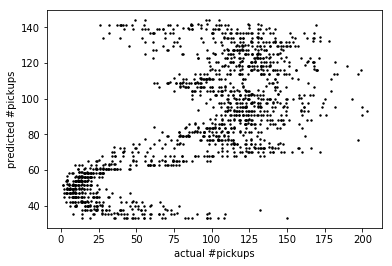

In [74]:
predictPickupsInArea(pickupsArea6, alg='linReg')

A linear regression does not seen to be that fitting for the prediction model...

Gaussian score on training set: 0.782508543264
Gaussian score on test set: 0.746481311702



Errors for nonevent day prediction:
Mean Absolute error (MAE): 17.60
Root Mean squared error: 23.93
Variance score: 0.76
R-squared: 0.76


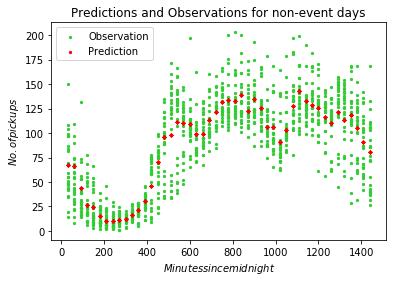

Errors for event day prediction:
Mean Absolute error (MAE): 14.11
Root Mean squared error: 20.11
Variance score: 0.83
R-squared: 0.83


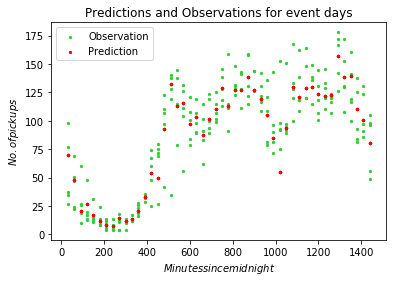

In [45]:
predictPickupsInArea(pickupsArea6)

Performing the Gaussian, however, gives quite a good model.
A mean absolute error of under 18 seems acceptable, predicting for event and non-event days.
The model seems to be a bit more precise for event days.

Mean Absolute error (MAE): 15.71
Root Mean squared error: 23.58
Variance score: 0.77
R-squared: 0.77


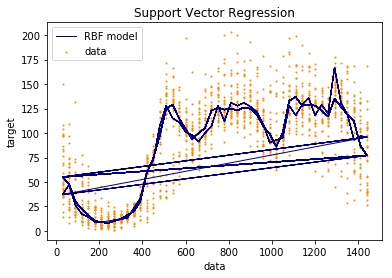

In [46]:
predictPickupsInArea(pickupsArea6, alg='svr_rbf')

# Examination of tips given to the taxi drivers

Another part to examine was the fact how many tips, if any, were given to the taxi drivers.
However, as the dataset contains negative fare_amounts, these should first be removed, as they should not be taken into consideration calculating the fare-tips-ratio.
The tips percentage is calculated, rounded to two decimals and added to the dataframe in another column. The tips_percentages with a value bigger than 1 are removed as it seems quite unlikely that someone would give more than 100 percent of tips.
As it does not make sense to use classes for each percentage of tips given, the percentage of tips given is again classified into a tipClass in steps of 5 percent (using classifyTips(tipPerc))

In [47]:
def calculateTipsPerc(fare, tips):
    return round(tips/fare, 2)

def classifyTips(tipPerc):
    if tipPerc <= 0.05:
        return 1
    elif tipPerc <= 0.1:
        return 2
    elif tipPerc <= 0.15:
        return 3
    elif tipPerc <= 0.2:
        return 4
    elif tipPerc <= 0.25:
        return 5
    elif tipPerc <= 0.3:
        return 6
    elif tipPerc <= 0.35:
        return 7
    else:
        return 8

def tipPreparation(df):
    # preparing data frame for analysis: removing negative and 0 fare_amounts
    df = df[df['fare_amount'] >0]
    
    # creating tip column percentage
    #tipsPerc = []
    #for x, y in zip(df['fare_amount'].values, df['tip_amount'].values):
    #    tipsPerc.append(round(calculateTipsPerc(x, y), 2))
        
    df['tips_perc'] = [round(tips/fare, 2) for fare, tips in zip(df['fare_amount'].values, df['tip_amount'].values)]
        
    # remove tips-perc that were more than 100%
    df = df[df['tips_perc'] <1]
    
    df['tipClass'] = [classifyTips(x) for x in df['tips_perc'].values]
    
    return df


def tipsHistPlot(df, col='tips_perc'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 160000, 20000))
    plt.hist(df[col], bins=20)
    plt.grid()
    plt.show()

In [48]:
pickupDF = tipPreparation(pickupDF)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
pickupDF.head()

,datetime,pickup_datetime,pickup_longitude,pickup_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count,...,lon,lat,weekday,time_of_day,min_since_midnight_group,location,kmeans_cluster,count,tips_perc,tipClass
0,2016-06-09 21:06:38,2016-06-09 21:06:38,-74.016121,40.710899,1,5.0,2.00,0.0,8.30,1,...,-74.016121,40.710899,1,night,1290,"(-74.0161209106, 40.710899353)",6,1,0.40,8
1,2016-06-09 21:09:53,2016-06-09 21:09:53,-74.008247,40.711269,1,10.0,3.39,0.0,14.69,1,...,-74.008247,40.711269,1,night,1290,"(-74.0082473755, 40.7112693787)",1,1,0.34,7
2,2016-06-09 21:09:55,2016-06-09 21:09:55,-74.016251,40.711048,1,19.0,4.06,0.0,24.36,1,...,-74.016251,40.711048,1,night,1290,"(-74.0162506104, 40.7110481262)",6,1,0.21,5
3,2016-06-09 21:06:00,2016-06-09 21:06:00,-74.003128,40.706345,1,20.0,2.20,0.0,23.50,1,...,-74.003128,40.706345,1,night,1290,"(-74.0031280518, 40.7063446045)",1,1,0.11,3
4,2016-06-09 21:06:02,2016-06-09 21:06:02,-73.987724,40.700386,1,11.5,1.00,0.0,13.80,1,...,-73.987724,40.700386,1,night,1290,"(-73.9877243042, 40.7003860474)",3,1,0.09,2


Looking at the histogram of the observed percentages of tips given, it becomes more clear why a division into 5 percent steps seems logic in this context:

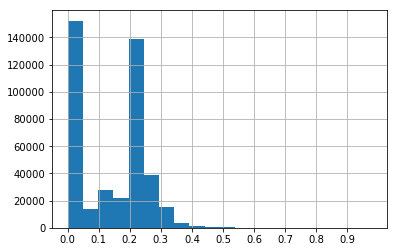

In [50]:
tipsHistPlot(pickupDF)

This is the histogram for the different classes of tips given:

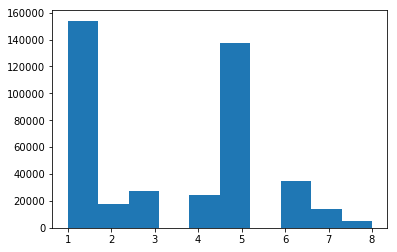

In [51]:
plt.hist(pickupDF['tipClass'])
plt.show()

In [52]:
pickupDF.columns

Index(['datetime', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'passenger_count', 'trip_distance', 'date', 'lon',
       'lat', 'weekday', 'time_of_day', 'min_since_midnight_group', 'location',
       'kmeans_cluster', 'count', 'tips_perc', 'tipClass'],
      dtype='object')

To create a model that can predict how much tip will be given, or rather, in which tip-cluster this trip will end up, we decided to use a RandomForestClassifier.
Before getting started, some of the columns need to be transformed into dummy variables as the numerical values would not make sense to use for these.

In [53]:
def createDummyDF(df):
    dummyColNames = ['payment_type', 'weekday', 'time_of_day', 'kmeans_cluster']
    df_with_dummies = pd.get_dummies(pickupDF, columns=dummyColNames)
    return df_with_dummies

In [56]:
pickupWithDummies = createDummyDF(pickupDF)

The columns relevant for the model are extracted from the dataframe in the function extractModelColumns(df):

In [57]:
def extractModelColumns(df):
    modelCols = ['trip_distance']
    modelCols.extend([col for col in df.columns if 'weekday_' in col])
    modelCols.extend([col for col in df.columns if 'payment_type_' in col])
    modelCols.extend([col for col in df.columns if 'passenger_count' in col])
    modelCols.extend([col for col in df.columns if 'kmeans_cluster_' in col])
    modelCols.extend([col for col in df.columns if 'time_of_day_' in col])
    return modelCols

In [58]:
def buildTipPredictionModel(df, modelCols, target='tipClass', alg='randomForest'):

    dftrain, dftest = createTrainAndTestSets(df)
    
    XTrain = dftrain[modelCols]
    targetTrain = dftrain[target]
    XTest = dftest[modelCols]
    targetTest = dftest[target]
    if alg=='randomForest':
        rfc = RandomForestClassifier(criterion='entropy') # entropy gives a better score for the first lassification with all the cols and does not make a difference for the second classification
        rfc.fit(XTrain, targetTrain)
        print("RandomForestClassifier with {} estimators".format(len(rfc.estimators_)))
        print("has a training score of "+ str(rfc.score(XTrain, targetTrain)))
        print("and a test score of "+str(rfc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(rfc.feature_importances_[i]))
        print('---Confusion Matrix---')
        cmForTipClassifiers(df, rfc, modelCols, target)
        return rfc
    
    elif alg=='decisionTree':
        dtc = DecisionTreeClassifier(max_depth=None)
        dtc.fit(XTrain, targetTrain)
        print("DecisionTreeClassifier with "+str(dtc.n_features_)+" features")
        print("has a training score of "+ str(dtc.score(XTrain, targetTrain)))
        print("and a test score of "+str(dtc.score(XTest, targetTest)))
        print("\nFeatures and their importances:\n")
        for i in range(0, len(modelCols)):
            print(str(modelCols[i])+": "+str(dtc.feature_importances_[i]))
        print('---Confusion Matrix---')
        cmForTipClassifiers(df, dtc, modelCols, target)
        return dtc

In [59]:
def cmForTipClassifiers(df, classifier, modelCols, target='tipClass'):
    testPrediction = classifier.predict(df[modelCols])
    cm = confusion_matrix(df[target], testPrediction)
    labels = list(classifier.classes_)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [60]:
model1Cols = extractModelColumns(pickupWithDummies)

DecisionTreeClassifier with 22 features
has a training score of 0.765814378217
and a test score of 0.591392416028

Features and their importances:

trip_distance: 0.247415744579
weekday_0: 0.00828739903949
weekday_1: 0.00875547911977
payment_type_1: 0.586736136738
payment_type_2: 0.0
payment_type_3: 2.35403838897e-08
payment_type_4: 0.0
passenger_count: 0.0783456882957
kmeans_cluster_0: 0.00559440936614
kmeans_cluster_1: 0.00633662582243
kmeans_cluster_2: 0.00402079932814
kmeans_cluster_3: 0.00629876172966
kmeans_cluster_4: 0.00201825825234
kmeans_cluster_5: 0.00438068805208
kmeans_cluster_6: 0.00697265402784
kmeans_cluster_7: 0.00325800596665
kmeans_cluster_8: 0.00439074320059
kmeans_cluster_9: 0.00393653097844
time_of_day_daytime: 0.00626041594064
time_of_day_evening_rush: 0.00767021012324
time_of_day_morning rush: 0.0032745086902
time_of_day_night: 0.00604691720927
---Confusion Matrix---
[[143366    386    534    526   8365    681    128     70]
 [   675   5460    530    448  10270 

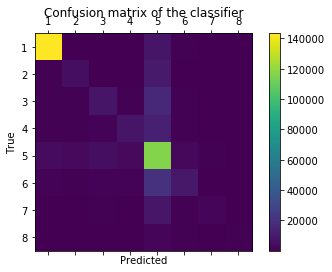

In [61]:
pickupDTC = buildTipPredictionModel(pickupWithDummies, model1Cols, alg='decisionTree')

RandomForestClassifier with 10 estimators
has a training score of 0.756707981722
and a test score of 0.599874394531

Features and their importances:

trip_distance: 0.494354477707
weekday_0: 0.00126614515491
weekday_1: 0.00136487397809
payment_type_1: 0.331678455754
payment_type_2: 0.120214836505
payment_type_3: 0.000580254235536
payment_type_4: 0.000589260670106
passenger_count: 0.0302688459896
kmeans_cluster_0: 0.00117455460495
kmeans_cluster_1: 0.00199207029748
kmeans_cluster_2: 0.000907279316654
kmeans_cluster_3: 0.00127691771129
kmeans_cluster_4: 0.00111948482792
kmeans_cluster_5: 0.00154650577961
kmeans_cluster_6: 0.0019408700925
kmeans_cluster_7: 0.000981651434509
kmeans_cluster_8: 0.0012394176198
kmeans_cluster_9: 0.000988659188703
time_of_day_daytime: 0.0015444315506
time_of_day_evening_rush: 0.00109431910902
time_of_day_morning rush: 0.00215234608798
time_of_day_night: 0.00172434238403
---Confusion Matrix---
[[141735    404    565    578   9321   1048    305    100]
 [   389 

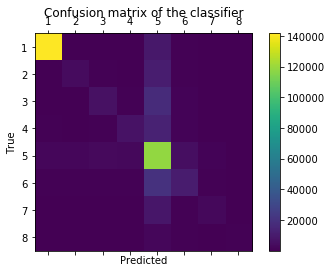

In [62]:
rfcdfwd = buildTipPredictionModel(pickupWithDummies, model1Cols)

As one can see here, the payment type and the trip distance have most importance on the tip given. So now we would like to find out how the score would look like taking into consideration only these columns when building a decision tree.

In [63]:
colsOfInterest = ['trip_distance']
colsOfInterest.extend([col for col in pickupWithDummies.columns if 'payment_type_' in col])

DecisionTreeClassifier with 5 features
has a training score of 0.663449530423
and a test score of 0.657053757697

Features and their importances:

trip_distance: 0.0506525364688
payment_type_1: 0.94934657224
payment_type_2: 0.0
payment_type_3: 8.91291649663e-07
payment_type_4: 0.0
---Confusion Matrix---
[[137101     20     51    328  16327    210      3     16]
 [   100    136     40    319  17218     29      3      0]
 [   137     35    244    508  26545     82      4      4]
 [   398     89    141   1793  21631    122     12      2]
 [   487    129    207   1343 134783    619     21     31]
 [   226     49     86    509  33500    713      5     20]
 [    75     12     32    150  13565    219     30     21]
 [    90      6      8     49   4675    244      0     35]]


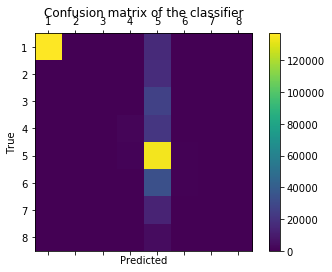

In [64]:
dt2 = buildTipPredictionModel(pickupWithDummies, colsOfInterest, alg='decisionTree')

RandomForestClassifier with 10 estimators
has a training score of 0.663759934743
and a test score of 0.656216387904

Features and their importances:

trip_distance: 0.136411718822
payment_type_1: 0.542160099159
payment_type_2: 0.314061273453
payment_type_3: 0.00606243823621
payment_type_4: 0.001304470329
---Confusion Matrix---
[[136956     15     37    321  16425    292      7      3]
 [    81     71     40    285  17293     70      2      3]
 [   115     18    192    438  26642    144      8      2]
 [   314     37    133   1511  21893    268     21     11]
 [   313     58    172   1049 135105    892     25      6]
 [   127     25     64    390  33560    923     18      1]
 [    30     10     27    128  13622    250     36      1]
 [    61      5      4     38   4683    304      1     11]]


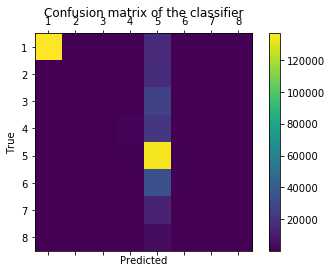

In [65]:
rfc2 = buildTipPredictionModel(pickupWithDummies, colsOfInterest)

Looking at the scores, this model seems not to be overfitted, but it is not too good either...
It seems like the predictions for classes 1 and 5 are very good and the other ones are quite bad, probably because they have too few members in general to produce a good model, so the classification of the tips should be reconsidered.

That is why we decided to use a new division into tipClasses:

In [66]:
def classifyTips2(x):
    if x < 0.05:
        return 1
    elif x < 0.2:
        return 2
    elif x < 0.25:
        return 3
    else:
        return 4

pickupWithDummies['tipClass2'] = [classifyTips2(x) for x in pickupWithDummies['tips_perc'].values]
tipTrain2, tipTest2 = createTrainAndTestSets(pickupWithDummies)

RandomForestClassifier with 10 estimators
has a training score of 0.77579423803
and a test score of 0.626547509908

Features and their importances:

trip_distance: 0.404777073961
weekday_0: 0.00106197199234
weekday_1: 0.00121351420094
payment_type_1: 0.199302851037
payment_type_2: 0.346697465688
payment_type_3: 0.00423967993852
payment_type_4: 0.00123649197891
passenger_count: 0.0209818840248
kmeans_cluster_0: 0.00103718926776
kmeans_cluster_1: 0.00246482483985
kmeans_cluster_2: 0.000545159480845
kmeans_cluster_3: 0.000796846858283
kmeans_cluster_4: 0.000940831781695
kmeans_cluster_5: 0.00108112303221
kmeans_cluster_6: 0.0021636902567
kmeans_cluster_7: 0.000789101026247
kmeans_cluster_8: 0.000732606408587
kmeans_cluster_9: 0.000764646418972
time_of_day_daytime: 0.00226202582941
time_of_day_evening_rush: 0.00154911716212
time_of_day_morning rush: 0.00303400677579
time_of_day_night: 0.0023278980401
---Confusion Matrix---
[[141057   1671   7508   2019]
 [  1051  21511  36774   4829]
 [  2

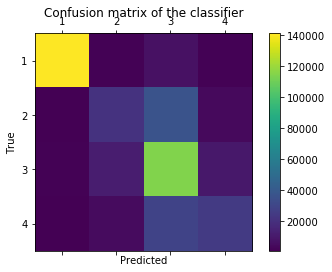

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
buildTipPredictionModel(pickupWithDummies, model1Cols, target='tipClass2', alg='randomForest')

DecisionTreeClassifier with 22 features
has a training score of 0.784207638834
and a test score of 0.621270636473

Features and their importances:

trip_distance: 0.241744611342
weekday_0: 0.00882962512896
weekday_1: 0.00810311596549
payment_type_1: 0.616003750539
payment_type_2: 0.0
payment_type_3: 0.0
payment_type_4: 0.0
passenger_count: 0.0640788388134
kmeans_cluster_0: 0.00524029903209
kmeans_cluster_1: 0.00483647770488
kmeans_cluster_2: 0.00327632617135
kmeans_cluster_3: 0.00478189472311
kmeans_cluster_4: 0.00184772251969
kmeans_cluster_5: 0.00282602894494
kmeans_cluster_6: 0.00490544880825
kmeans_cluster_7: 0.0034148504486
kmeans_cluster_8: 0.00350316257235
kmeans_cluster_9: 0.00300213951602
time_of_day_daytime: 0.0044187977888
time_of_day_evening_rush: 0.00739886127895
time_of_day_morning rush: 0.00207623008097
time_of_day_night: 0.00971181862136
---Confusion Matrix---
[[142495   1588   6708   1464]
 [  1741  25591  33506   3327]
 [  3404  16076 112760   6937]
 [  1701   6663  2

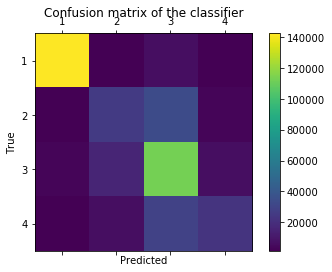

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [68]:
buildTipPredictionModel(pickupWithDummies, model1Cols, target='tipClass2', alg='decisionTree')

DecisionTreeClassifier with 5 features
has a training score of 0.67538565932
and a test score of 0.669910271495

Features and their importances:

trip_distance: 0.0593053776586
payment_type_1: 0.940694622341
payment_type_2: 0.0
payment_type_3: 0.0
payment_type_4: 0.0
---Confusion Matrix---
[[136663    302  13366   1924]
 [    96   1589  59320   3160]
 [   176   1524 128548   8929]
 [    94    731  46042  13123]]


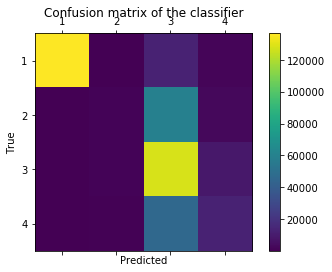

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [69]:
buildTipPredictionModel(pickupWithDummies, colsOfInterest, target='tipClass2', alg='decisionTree')

DecisionTreeClassifier with 5 features
has a training score of 0.675479502487
and a test score of 0.670328956392

Features and their importances:

trip_distance: 0.0586534061009
payment_type_1: 0.941346593338
payment_type_2: 5.61082366281e-10
payment_type_3: 0.0
payment_type_4: 0.0
---Confusion Matrix---
[[136688    239  13483   1845]
 [    86   1307  59801   2971]
 [   190   1182 129322   8483]
 [   128    556  46616  12690]]


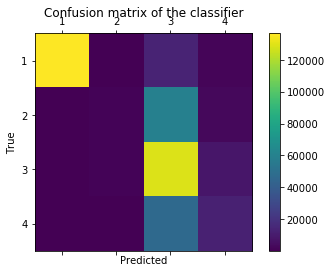

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
buildTipPredictionModel(pickupWithDummies, colsOfInterest, target='tipClass2', alg='decisionTree')

Using the new class division, the model gets a bit better, at least for the RandomForestClassifier. As observed above, the classes 1 and 3 get the best fits. This is a result of these classes having the most members, as it can be observed in the following histogram:

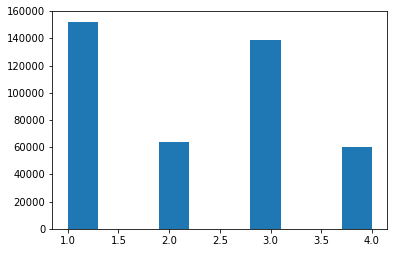

In [71]:
plt.hist(pickupWithDummies['tipClass2'])
plt.show()

# Conclusion
The area around Barclays center is a very popular area in general and there are high demands for taxi transport most of the afternoons
People leave approx x hours after the end of an event
The longer distances traveled, the more tips are givene (?)